# Stress Region Predictor: Data Collection Pipeline

This notebook orchestrates the data collection and preprocessing steps for the Stress Region Predictor project.

**Pipeline Overview:**
1. **Scraping**: Collects stress-response motifs from PlantCARE.
2. **Parsing**: Processes the local PLACE database HTML file.
3. **Merging**: Combines datasets into a unified library.
4. **Quality Control**: Checks sequences and generates logos.
5. **Enrichment**: Maps motifs to real genomic coordinates and extracts flanking sequences using NCBI Entrez.

---

## 1. PlantCARE Database Scraping (Basic Report)
*Retrieves the initial list of motifs and accessions.*

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from urllib.parse import urljoin
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# =============================================================================
# KONFIGURASI
# =============================================================================
url_form = "https://bioinformatics.psb.ugent.be/webtools/plantcare/cgi-bin/qfm_querycare.htpl"
output_file = "PlantCARE_Vertical_Report.csv"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Setup Koneksi
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

all_data = []

print("--- MULAI SCRAPING (MODE LAPORAN VERTIKAL) ---")
print("==============================================")

# 1. Buka Halaman Awal
try:
    r = session.get(url_form, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    form = soup.find('form')
    action = form.get('action')
    url_target = urljoin(url_form, action)
    
    payload = {
        'query': '', 
        'submit': 'Submit Query', 
        '.cgifields': 'query'
    }
except Exception as e:
    print(f"Error awal: {e}")
    exit()

# 2. Loop Halaman
current_url = url_target
halaman = 1
last_valid_id = "Unknown"
total_counter = 0

# Variabel deteksi looping
previous_page_data = [] 

while True:
    print(f"\n>> MEMPROSES HALAMAN {halaman}...")
    
    try:
        response = session.post(current_url, data=payload, headers=headers, timeout=30)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        rows = soup.find_all('tr')
        current_page_data = []
        
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 2:
                col_id = cols[0].get_text(strip=True)
                col_seq = cols[-1].get_text(strip=True).upper()
                
                # Update ID jika ada
                if col_id and "ID of" not in col_id:
                    last_valid_id = col_id
                
                # SAYA PERLEBAR FILTERNYA
                # Mengizinkan kode IUPAC (R,Y,M,K,S,W,H,B,V,D) jaga-jaga kalau ada variasi
                valid_chars = "ACGTURYSWKMBDHVN()-0123456789"
                
                if len(col_seq) >= 3 and all(c in valid_chars for c in col_seq):
                    
                    total_counter += 1
                    
                    # --- CETAK VERTIKAL (REPORT) ---
                    print(f"   [{total_counter}] ID: {last_valid_id:<20} | Seq: {col_seq}")
                    
                    entry = {
                        'ID': last_valid_id, 
                        'Sequence': col_seq,
                        'Raw_Check': row.get_text(strip=True) 
                    }
                    current_page_data.append(entry)

        # --- CEK LOOPING ---
        if len(current_page_data) > 0 and current_page_data == previous_page_data:
            print("\n[STOP] Halaman ini SAMA PERSIS dengan sebelumnya. Selesai.")
            break
        
        if current_page_data:
            for item in current_page_data:
                final_item = {k: v for k, v in item.items() if k != 'Raw_Check'}
                all_data.append(final_item)
            previous_page_data = current_page_data
        else:
             print("   [INFO] Tidak ada sequence di halaman ini (mungkin header/footer).")

        # --- NEXT BUTTON ---
        next_btn = soup.find('input', {'value': re.compile(r'>>')})
        
        if next_btn:
            form_next = next_btn.find_parent('form')
            payload = {}
            for inp in form_next.find_all('input'):
                if inp.get('name'):
                    payload[inp.get('name')] = inp.get('value')
            
            payload[next_btn.get('name')] = next_btn.get('value')
            
            if form_next.get('action'):
                current_url = urljoin(url_form, form_next.get('action'))
            
            halaman += 1
        else:
            print("\n[SELESAI] Tombol Next habis.")
            break

    except Exception as e:
        print(f"\n[ERROR] {e}")
        break

# 3. Simpan
if all_data:
    print("\n==============================================")
    print("              REKAPITULASI DATA               ")
    print("==============================================")
    df = pd.DataFrame(all_data)
    print(f"Total Baris Terkumpul : {len(df)}")
    
    df.to_csv(output_file, index=False)
    print(f"File tersimpan di     : {output_file}")
else:
    print("Zonk.")

--- MULAI SCRAPING (MODE LAPORAN VERTIKAL) ---

>> MEMPROSES HALAMAN 1...
   [1] ID: H-box module         | Seq: AGCACCATACTTGGTA
   [2] ID: AAGAA-motif          | Seq: GAAAGAA
   [3] ID: AAGAA-motif          | Seq: GGTAAAGAAA
   [4] ID: CTAG-motif           | Seq: ACTAGCAGAA
   [5] ID: GT1-motif            | Seq: GGTTAAT
   [6] ID: GT1-motif            | Seq: ACAGAAGTAGGTTAATCAATTTCAGGTTAATCAAAGTGGAGATCGGAAAG

>> MEMPROSES HALAMAN 2...
   [7] ID: PE1                  | Seq: GGAAATAGCAAATGTTAAAAATA
   [8] ID: RE1                  | Seq: GGGCGCGGAACAAGGATCGGCGCGCCACGCC
   [9] ID: TATA-box             | Seq: TATATTTATATTT
   [10] ID: ABRE                 | Seq: TACGGTC
   [11] ID: ABRE                 | Seq: CACGTG
   [12] ID: ABRE                 | Seq: ACGTG
   [13] ID: ABRE                 | Seq: AACCCGG
   [14] ID: AC-I                 | Seq: GCTTACCTACCA
   [15] ID: ACA-motif            | Seq: AATCACAACCATA
   [16] ID: ACTCATCCT sequence   | Seq: ACTCATCCT

>> MEMPROSES HALAMAN 3...

## 2. Advanced Scraping: Retrieving Gene IDs
*Re-scrapes PlantCARE to extract specific Gene IDs associated with motifs, enabling valid genomic mapping.*

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from urllib.parse import urljoin
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# =============================================================================
# KONFIGURASI
# =============================================================================
url_form = "https://bioinformatics.psb.ugent.be/webtools/plantcare/cgi-bin/qfm_querycare.htpl"
output_file = "PlantCARE_Complete_With_GeneID.csv"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Setup Koneksi
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

all_data = []

print("--- MULAI SCRAPING (ID + GENE ID + SEQUENCE) ---")
print("==================================================")

# 1. Buka Halaman Awal
try:
    r = session.get(url_form, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    form = soup.find('form')
    action = form.get('action')
    url_target = urljoin(url_form, action)
    
    payload = {
        'query': '', 
        'submit': 'Submit Query', 
        '.cgifields': 'query'
    }
except Exception as e:
    print(f"Error awal: {e}")
    exit()

# 2. Loop Halaman
current_url = url_target
halaman = 1
last_valid_id = "Unknown"
total_counter = 0

# Variabel deteksi looping
previous_page_data = [] 

while True:
    print(f"\n>> MEMPROSES HALAMAN {halaman}...")
    
    try:
        response = session.post(current_url, data=payload, headers=headers, timeout=30)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        rows = soup.find_all('tr')
        current_page_data = []
        
        for row in rows:
            cols = row.find_all('td')
            # Pastikan kolom cukup banyak untuk mengambil Gene ID
            if len(cols) >= 2:
                col_id = cols[0].get_text(strip=True)
                col_seq = cols[-1].get_text(strip=True).upper()
                
                # --- LOGIKA PENGAMBILAN GENE ID ---
                # Gene ID biasanya ada di kolom kedua dari kanan (sebelum sequence)
                # Kita cek apakah kolomnya cukup (minimal 4 kolom untuk aman)
                col_gene_id = "-"
                if len(cols) >= 4:
                    col_gene_id = cols[-2].get_text(strip=True)
                
                # Update ID jika ada isinya
                if col_id and "ID of" not in col_id:
                    last_valid_id = col_id
                
                # Filter DNA (Valid Characters)
                valid_chars = "ACGTURYSWKMBDHVN()-0123456789"
                
                if len(col_seq) >= 3 and all(c in valid_chars for c in col_seq):
                    
                    total_counter += 1
                    
                    # --- CETAK VERTIKAL (REPORT LENGKAP) ---
                    # Format: No | ID | GeneID | Sequence
                    print(f"   [{total_counter}] ID: {last_valid_id:<15} | GeneID: {col_gene_id:<10} | Seq: {col_seq}")
                    
                    entry = {
                        'ID': last_valid_id, 
                        'Gene_ID': col_gene_id,  # <--- DATA BARU DISINI
                        'Sequence': col_seq,
                        'Raw_Check': row.get_text(strip=True) 
                    }
                    current_page_data.append(entry)

        # --- CEK LOOPING (Anti-Macet) ---
        if len(current_page_data) > 0 and current_page_data == previous_page_data:
            print("\n[STOP] Halaman ini SAMA PERSIS dengan sebelumnya. Selesai.")
            break
        
        if current_page_data:
            # Pindahkan data bersih ke list utama
            for item in current_page_data:
                final_item = {k: v for k, v in item.items() if k != 'Raw_Check'}
                all_data.append(final_item)
            previous_page_data = current_page_data
        else:
             print("   [INFO] Tidak ada sequence di halaman ini.")

        # --- NEXT BUTTON ---
        next_btn = soup.find('input', {'value': re.compile(r'>>')})
        
        if next_btn:
            form_next = next_btn.find_parent('form')
            payload = {}
            for inp in form_next.find_all('input'):
                if inp.get('name'):
                    payload[inp.get('name')] = inp.get('value')
            
            payload[next_btn.get('name')] = next_btn.get('value')
            
            if form_next.get('action'):
                current_url = urljoin(url_form, form_next.get('action'))
            
            halaman += 1
        else:
            print("\n[SELESAI] Tombol Next habis.")
            break

    except Exception as e:
        print(f"\n[ERROR] {e}")
        break

# 3. Simpan
if all_data:
    print("\n==============================================")
    print("              REKAPITULASI DATA               ")
    print("==============================================")
    df = pd.DataFrame(all_data)
    print(f"Total Baris Terkumpul : {len(df)}")
    
    # Simpan ke CSV dengan kolom baru
    df.to_csv(output_file, index=False)
    print(f"File tersimpan di     : {output_file}")
    print(f"Kolom File CSV        : ID, Gene_ID, Sequence")
else:
    print("Zonk.")

--- MULAI SCRAPING (ID + GENE ID + SEQUENCE) ---

>> MEMPROSES HALAMAN 1...
   [1] ID: H-box module    | GeneID: X03710     | Seq: AGCACCATACTTGGTA
   [2] ID: AAGAA-motif     | GeneID: phyA3      | Seq: GAAAGAA
   [3] ID: AAGAA-motif     | GeneID: phyA3      | Seq: GGTAAAGAAA
   [4] ID: CTAG-motif      | GeneID: phyA3      | Seq: ACTAGCAGAA
   [5] ID: GT1-motif       | GeneID: phyA3      | Seq: GGTTAAT
   [6] ID: GT1-motif       | GeneID: phyA3      | Seq: ACAGAAGTAGGTTAATCAATTTCAGGTTAATCAAAGTGGAGATCGGAAAG

>> MEMPROSES HALAMAN 2...
   [7] ID: PE1             | GeneID: 5d dark oat | Seq: GGAAATAGCAAATGTTAAAAATA
   [8] ID: RE1             | GeneID: 5d dark oat | Seq: GGGCGCGGAACAAGGATCGGCGCGCCACGCC
   [9] ID: TATA-box        | GeneID: phyA3      | Seq: TATATTTATATTT
   [10] ID: ABRE            | GeneID: D13044     | Seq: TACGGTC
   [11] ID: ABRE            | GeneID: U01377     | Seq: CACGTG
   [12] ID: ABRE            | GeneID: AB000615   | Seq: ACGTG
   [13] ID: ABRE            | GeneI

## 3. PLACE Database Parsing (Local Processing)
*Parses the raw HTML report from the PLACE database to extract motifs and metadata.*

In [9]:
import re
import pandas as pd
from bs4 import BeautifulSoup
import os

# =============================================================================
# KONFIGURASI PATH
# =============================================================================
input_path = "/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/place.seq.html"
output_file = "PLACE_Parsed_Complete_V2.csv"

def parse_place_html_v2(file_path):
    print(f"Membaca file: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"[ERROR] File tidak ditemukan.")
        return []

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        raw_content = f.read()

    # Bersihkan HTML
    soup = BeautifulSoup(raw_content, "html.parser")
    text_content = soup.get_text(separator="\n")
    entries = text_content.split('//')
    
    parsed_data = []
    print(f"Memproses {len(entries)} blok data...")

    for entry in entries:
        entry = entry.strip()
        if not entry: continue 

        # 1. AMBIL ID
        id_match = re.search(r'^ID\s+(.+)', entry, re.MULTILINE)
        val_id = id_match.group(1).strip() if id_match else "Unknown"

        # 2. AMBIL ACCESSION (GENBANK / EMBL / DDBJ)
        # Regex ini mencari salah satu dari 3 kata kunci tersebut
        # Format: "Database: Kode"
        acc_match = re.search(r'(GenBank|EMBL|DDBJ):\s*([A-Z0-9]+)', entry, re.IGNORECASE)
        
        if acc_match:
            # Simpan sumbernya (misal: EMBL) dan kodenya
            val_source = acc_match.group(1) 
            val_accession = acc_match.group(2).strip()
        else:
            val_source = "-"
            val_accession = "-"

        # 3. AMBIL PUBMED (Cadangan identitas)
        pm_match = re.search(r'PubMed:\s*(\d+)', entry, re.IGNORECASE)
        val_pubmed = pm_match.group(1).strip() if pm_match else "-"

        # 4. AMBIL PLACE AC
        ac_match = re.search(r'^AC\s+(.+)', entry, re.MULTILINE)
        val_place_ac = ac_match.group(1).strip() if ac_match else "-"

        # 5. AMBIL SEQUENCE
        val_seq = ""
        if 'SQ' in entry:
            parts = re.split(r'\nSQ.*\n', entry, maxsplit=1) 
            if len(parts) > 1:
                val_seq = re.sub(r'[^a-zA-Z]', '', parts[1]).upper()

        if val_seq:
            parsed_data.append({
                'ID': val_id,
                'GenBank_EMBL_ID': val_accession,  # Gabungan GenBank/EMBL
                'Source_DB': val_source,           # Asal databasenya
                'PubMed_ID': val_pubmed,           # Referensi Jurnal
                'Sequence': val_seq,
                'PLACE_AC': val_place_ac
            })

    return parsed_data

# =============================================================================
# EKSEKUSI
# =============================================================================
data_hasil = parse_place_html_v2(input_path)

if data_hasil:
    df = pd.DataFrame(data_hasil)
    
    # Reorder Columns
    df = df[['ID', 'GenBank_EMBL_ID', 'Source_DB', 'PubMed_ID', 'Sequence', 'PLACE_AC']]
    
    print("\n--- PREVIEW DATA BARU ---")
    print(df.head())
    
    print("\n--- STATISTIK UPDATE ---")
    print(f"Total Sequence : {len(df)}")
    print(f"Punya GenBank/EMBL : {len(df[df['GenBank_EMBL_ID'] != '-'])}")
    print(f"Punya PubMed ID    : {len(df[df['PubMed_ID'] != '-'])}")
    
    df.to_csv(output_file, index=False)
    print(f"\n[SUKSES] File tersimpan: {output_file}")
else:
    print("Zonk.")

Membaca file: /Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/place.seq.html ...
Memproses 470 blok data...

--- PREVIEW DATA BARU ---
                ID GenBank_EMBL_ID Source_DB PubMed_ID  \
0      -10PEHVPSBD               -         -  11587507   
1        -141NTG13          M62855   GenBank   1921969   
2  -284MOTIFZMSBE1               -         -  10482678   
3         -300CORE          X03103   GenBank   4059057   
4      -300ELEMENT               -         -  15467781   

                         Sequence PLACE_AC  
0                          TATTCT  S000392  
1           GCTTTTGATGACTTCAAACAC  S000335  
2  CGTGCAAGCCCAAAGGCCAATCGGCCCAGA  S000285  
3                         TGTAAAG  S000001  
4                        TGHAAARK  S000122  

--- STATISTIK UPDATE ---
Total Sequence : 469
Punya GenBank/EMBL : 68
Punya PubMed ID    : 453

[SUKSES] File tersimpan: PLACE_Parsed_Complete_V2.csv


## 4. Helper: Simplify PLACE Dataset
*Extracts just the ID and Sequence columns for easy merging.*

In [10]:
import os
import pandas as pd

# Save only ID and Sequence columns to a separate CSV
output_simple_file = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'

df_result = pd.read_csv('/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq.csv')

if 'df_result' in locals():
    # Use dataframe from memory if available
    df_subset = df_result[['ID', 'Sequence']]
    df_subset.to_csv(output_simple_file, index=False)
    print(f"Saved simplified data (ID, Sequence) to '{output_simple_file}'.")
    print(df_subset.head())
elif os.path.exists('place_seq.csv'):
    # Load from the CSV generated in the previous step
    df_loaded = pd.read_csv('place_seq.csv')
    df_subset = df_loaded[['ID', 'Sequence']]
    df_subset.to_csv(output_simple_file, index=False)
    print(f"Saved simplified data (ID, Sequence) to '{output_simple_file}'.")
    print(df_subset.head())
else:
    print("No data found to process. Please run the previous cell first.")

Saved simplified data (ID, Sequence) to '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'.
                ID                        Sequence
0      -10PEHVPSBD                          TATTCT
1        -141NTG13           GCTTTTGATGACTTCAAACAC
2  -284MOTIFZMSBE1  CGTGCAAGCCCAAAGGCCAATCGGCCCAGA
3         -300CORE                         TGTAAAG
4      -300ELEMENT                        TGHAAARK


## 5. Merging Datasets (PlantCARE + PLACE)
*Combines both sources, removes duplicates, and standardizes format.*

In [11]:
# Merge datasets with priority to PlantCARE
plantcare_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/PlantCARE_Vertical_Report.csv'
placeseq_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'
output_merged_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv'

if os.path.exists(plantcare_path) and os.path.exists(placeseq_path):
    print("Loading datasets...")
    df_plantcare = pd.read_csv(plantcare_path)
    df_placeseq = pd.read_csv(placeseq_path)
    
    # Standardize column names if needed (assuming ID, Sequence)
    # Just to be safe, strip whitespace
    df_plantcare.columns = [c.strip() for c in df_plantcare.columns]
    df_placeseq.columns = [c.strip() for c in df_placeseq.columns]

    print(f"PlantCARE entries: {len(df_plantcare)}")
    print(f"PlaceSeq entries: {len(df_placeseq)}")

    # Normalize sequences for comparison (uppercase, strip)
    df_plantcare['Sequence'] = df_plantcare['Sequence'].astype(str).str.upper().str.strip()
    df_placeseq['Sequence'] = df_placeseq['Sequence'].astype(str).str.upper().str.strip()

    # Add source column for tracking (optional)
    df_plantcare['Source'] = 'PlantCARE'
    df_placeseq['Source'] = 'PlaceSeq'

    # Concatenate with PlantCARE FIRST so it is earlier in the index
    df_merged = pd.concat([df_plantcare, df_placeseq], ignore_index=True)

    # Drop duplicates based on 'Sequence', keeping 'first' (which is PlantCARE)
    df_unique = df_merged.drop_duplicates(subset=['Sequence'], keep='first')
    
    print(f"Total Combined: {len(df_merged)}")
    print(f"Unique Sequences: {len(df_unique)}")
    print(f"Duplicates Removed: {len(df_merged) - len(df_unique)}")
    print("Source distribution in final set:")
    print(df_unique['Source'].value_counts())

    # Save final result (removing Source column to keep format clean)
    df_final = df_unique[['ID', 'Sequence']]
    df_final.to_csv(output_merged_path, index=False)
    print(f"Merged file saved to: {output_merged_path}")
    print(df_final.head())
else:
    print(f"Files not found. Check paths:\n{plantcare_path}\n{placeseq_path}")

Loading datasets...
PlantCARE entries: 365
PlaceSeq entries: 469
Total Combined: 834
Unique Sequences: 735
Duplicates Removed: 99
Source distribution in final set:
Source
PlaceSeq     422
PlantCARE    313
Name: count, dtype: int64
Merged file saved to: /Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv
             ID          Sequence
0  H-box module  AGCACCATACTTGGTA
1   AAGAA-motif           GAAAGAA
2   AAGAA-motif        GGTAAAGAAA
3    CTAG-motif        ACTAGCAGAA
4     GT1-motif           GGTTAAT


## 6. QC & Visualization (Feature Logo)
*Validates sequence integrity and generates a sequence logo to visualize consensus patterns.*

Logo saved to: /Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq_logo.png


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'H' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'K' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'M' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'N' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warnin

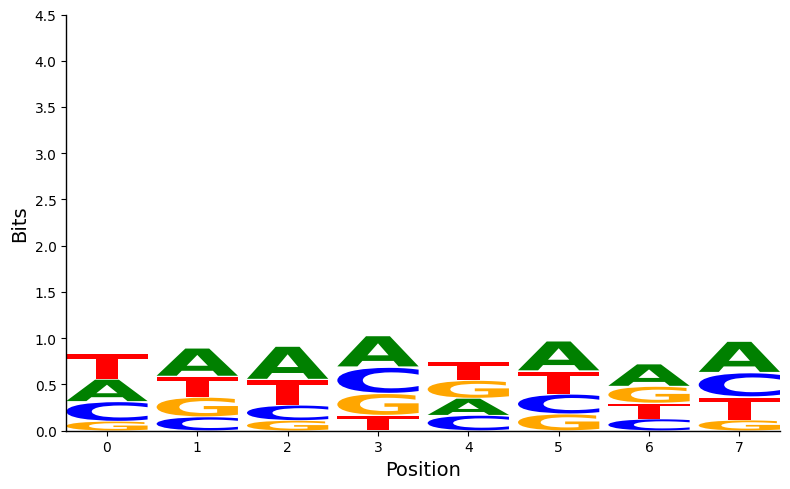

In [15]:
# Ensure project path is on sys.path so we can import local modules
import sys
from pathlib import Path
proj_root = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor'
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

# Run the sequence checker and produce a DNA logo PNG (no CSVs written)
import importlib
import plot.logo as pl
importlib.reload(pl)

check_sequences = pl.check_sequences
create_logo_from_list = pl.create_logo_from_list

merged = Path('/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv')
out_png = merged.with_name(merged.stem + '_logo.png')

if merged.exists():
    # validate sequences in-memory (no output CSV)
    df_checked = check_sequences(str(merged), out_path=None)
    df_valid = df_checked[df_checked['Valid'] == True]
    if df_valid.empty:
        print('No valid sequences to plot.')
    else:
        sequences = df_valid['Sequence'].astype(str).tolist()
        png_path = create_logo_from_list(sequences, str(merged.parent), merged.stem + '_logo', clean_noise=True, seq_type='dna')
        print(f'Logo saved to: {png_path}')
else:
    print(f"Merged file not found: {merged}")

## 7. Genomic Context Extraction (Flanking Sequences)
*Connects to NCBI to download the full genomic sequence for each gene and extracts 50bp flanking regions around the motif site. This creates the training data.*

In [ ]:
# =============================================================================
# EXTRACT GENOMIC CONTEXT (FLANKING SEQUENCES) - MERGED (PLANTCARE + PLACE)
# =============================================================================
from Bio import Entrez
from Bio.Seq import Seq
import pandas as pd
import time
import os
import re

# 1. Configure NCBI Entrez
Entrez.email = "plantbert_finetune@example.com" 

# 2. Load Datasets
plantcare_csv = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/PlantCARE_Complete_With_GeneID.csv'
place_csv = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/PLACE_Parsed_Complete_V2.csv'

dfs_to_merge = []

# Load PlantCARE
if os.path.exists(plantcare_csv):
    df_pc = pd.read_csv(plantcare_csv)
    # Norm Columns
    df_pc = df_pc[['ID', 'Gene_ID', 'Sequence']].copy()
    df_pc['Source'] = 'PlantCARE'
    dfs_to_merge.append(df_pc)
    print(f"Loaded PlantCARE: {len(df_pc)} rows")

# Load PLACE
if os.path.exists(place_csv):
    df_pl = pd.read_csv(place_csv)
    # Filter valid IDs
    df_pl = df_pl[df_pl['GenBank_EMBL_ID'] != '-'].copy()
    # Norm Columns
    df_pl = df_pl.rename(columns={'GenBank_EMBL_ID': 'Gene_ID'})
    df_pl = df_pl[['ID', 'Gene_ID', 'Sequence']].copy()
    df_pl['Source'] = 'PLACE'
    dfs_to_merge.append(df_pl)
    print(f"Loaded PLACE (valid IDs): {len(df_pl)} rows")

if not dfs_to_merge:
    print("No input files found.")
    exit()

# Merge
df_merged = pd.concat(dfs_to_merge, ignore_index=True)
print(f"Total Combined Raw: {len(df_merged)}")

# 3. Filter for valid Gene IDs (Strict Check)
invalid_ids = ['synthetic', 'unknown', '?', 'roots', 'leaves', 'seeds', 'nodule', 'rec(', 'diploid', '-', 'nan']

def is_valid_gene_id(val):
    s = str(val).strip().lower()
    if not s or s == 'nan': return False
    for inv in invalid_ids:
        if inv in s: return False
    # GenBank IDs usually start with Letter
    return s[0].isalpha()

df_wd = df_merged[df_merged['Gene_ID'].apply(is_valid_gene_id)].copy()
# Remove duplicates (GeneID + Sequence)
df_wd = df_wd.drop_duplicates(subset=['Gene_ID', 'Sequence'])

print(f"Entries to Process (Unique Valid IDs): {len(df_wd)}")
print(df_wd['Source'].value_counts())

# helper: IUPAC to Regex
iu_map = {
    'R': '[AG]', 'Y': '[CT]', 'M': '[AC]', 'K': '[GT]', 'S': '[GC]', 'W': '[AT]',
    'H': '[ACT]', 'B': '[CGT]', 'V': '[ACG]', 'D': '[AGT]', 'N': '[ACGT]'
}

def to_regex(seq):
    seq = seq.upper()
    res = ""
    for c in seq:
        res += iu_map.get(c, c)
    return res

# 4. Define Fetch Function
def fetch_flanking_sequence(accession_str, motif_seq, flank_bp=50):
    try:
        # Clean ID
        acc = str(accession_str).strip()
        if ":" in acc: acc = acc.split(":")[-1].strip()
        
        # Fetch FASTA
        with Entrez.efetch(db="nucleotide", id=acc, rettype="fasta", retmode="text") as handle:
            record = handle.read()
        
        lines = record.strip().split('\n')
        if not lines: return None, "Empty response"
        full_seq = "".join(lines[1:]).upper() # Skip header
        
        motif_clean = str(motif_seq).upper().strip().replace('U', 'T')

        # Search Strategy: Forward, then Reverse, then Regex
        start_idx = full_seq.find(motif_clean)
        
        if start_idx == -1:
            rc_seq = str(Seq(motif_clean).reverse_complement())
            start_idx = full_seq.find(rc_seq)
        
        if start_idx == -1:
            pattern = to_regex(motif_clean)
            match = re.search(pattern, full_seq)
            if match: start_idx = match.start()

        if start_idx == -1:
            return None, f"Motif {motif_clean} not found in {len(full_seq)}bp gene {acc}."
        
        # Extract Flanks
        s = max(0, start_idx - flank_bp)
        m_len = len(motif_clean) 
        e = min(len(full_seq), start_idx + m_len + flank_bp)
        
        expanded_seq = full_seq[s:e]
        return expanded_seq, "Success"

    except Exception as e:
        return None, f"Error: {str(e)}"

# 5. Run on ALL valid data
print("\n--- Starting Flank Extraction (MERGED DATASET) ---")
results = []

total_to_process = len(df_wd)
print(f"Total to process: {total_to_process}...")

for idx, row in df_wd.iterrows():
    gid = row['Gene_ID']
    mid = row['ID']
    mseq = row['Sequence']
    source = row['Source']
    
    # Progress Logger
    if len(results) % 50 == 0:
        print(f"Processing {idx+1}/{total_to_process}: {mid} ({source} - {gid})...")
        
    expanded, msg = fetch_flanking_sequence(gid, mseq, flank_bp=50)
    
    if expanded:
        results.append({
            'ID': mid,
            'Gene_ID': gid,
            'Original_Motif': mseq,
            'Expanded_Sequence': expanded,
            'Length': len(expanded),
            'Source': source
        })
    else:
        # Keep track of failures? optional
        pass
    
    time.sleep(0.2) 

print(f"\nExtraction Complete. Success Rate: {len(results)}/{len(df_wd)}")

if len(results) > 0:
    df_results = pd.DataFrame(results)
    save_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_expanded_50bp.csv'
    df_results.to_csv(save_path, index=False)
    print(f"Saved merged expanded dataset to: {save_path}")

Loaded PlantCARE: 365 rows
Loaded PLACE (valid IDs): 68 rows
Total Combined Raw: 433
Entries to Process (Unique Valid IDs): 385
Source
PlantCARE    322
PLACE         63
Name: count, dtype: int64

--- Starting Flank Extraction (MERGED DATASET) ---
Total to process: 385...
Processing 1/385: H-box module (PlantCARE - X03710)...
Processing 2/385: AAGAA-motif (PlantCARE - phyA3)...
Processing 3/385: AAGAA-motif (PlantCARE - phyA3)...
Processing 4/385: CTAG-motif (PlantCARE - phyA3)...
Processing 5/385: GT1-motif (PlantCARE - phyA3)...
Processing 6/385: GT1-motif (PlantCARE - phyA3)...
Processing 9/385: TATA-box (PlantCARE - phyA3)...
Processing 10/385: ABRE (PlantCARE - D13044)...
Processing 11/385: ABRE (PlantCARE - U01377)...
Processing 76/385: TATA-box (PlantCARE - X67833)...
Processing 135/385: CCAAT-box (PlantCARE - X58339)...
Processing 197/385: Box II -like sequence (PlantCARE - X52153)...
Processing 265/385: Box II (PlantCARE - M21356)...
Processing 332/385: Footprint A (PlantCARE -